<h1>Real-world/Business problem </h1>

<p> <b>Source</b>:https://www.kaggle.com/therohk/ireland-historical-news </p>
<p> <b>Data</b>: The Irish Times - Waxy-Wany News</p>
<p> Download irishtimes-date-text from Kaggle.</p> 
<p> <b>Problem statement</b> : </p>
<p> Classify the given text into different genre such as business, sports etc . </p>


 <h2> Mapping the real-world problem to an ML problem </h2>

<h4> <p>Type of Machine Learning Problem</p></h4>
<p>There are 156 different classes.for the particular problem out of 156 classes i have considered 3 classes. A given text can be classified into 3 different classes.so It is a Multi class classification problem</p>
<h4>Performance Metric : </h4>
<p>1.Multi class log-loss </p>
<p>2.Confusion matrix </p>
<h4> Machine Learing Objectives and Constraints :</h4>
<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
<p> Constraints:</p>
<p>1.No Interpretability</p>
<p>2.Class probabilities are needed</p>
<p>3.No Latency constraints</p>
<h4>splitting of data into Train, CV and Test Datasets</h4>
<p> Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively</p>

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
import math
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

## Data Exploration :

In [12]:
df = pd.read_csv('irishtimes-date-text.csv')
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])
print('Features : ', df.columns.values)
df.head()

Number of data points :  1425460
Number of features :  3
Features :  ['publish_date' 'headline_category' 'headline_text']


,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life


In [13]:
df['headline_category'].value_counts()

news                                                         574774
sport                                                        153559
business                                                     106155
opinion.letters                                               70262
opinion                                                       38413
                                                              ...  
business.exchange-rates                                           3
lifestyle.coffee-vs-gangs                                         2
lifestyle.travel.hotels                                           2
lifestyle.abroad.canada                                           2
lifestyle.fashion.beauty.beauty-report-with-laura-kennedy         1
Name: headline_category, Length: 156, dtype: int64

#### Considering only 3 classes out of 156 categories :

In [14]:
print("There are {} classes in the dataset".format(len(df['headline_category'].value_counts().keys())))
data=df.ix[(df['headline_category']== 'news') | (df['headline_category'] == 'sport') | (df['headline_category'] == 'business')]
data['headline_category'].value_counts()

There are 156 classes in the dataset


news        574774
sport       153559
business    106155
Name: headline_category, dtype: int64

In [15]:
data['headline_category'].value_counts()

news        574774
sport       153559
business    106155
Name: headline_category, dtype: int64

## Data Cleaning :

In [16]:
data[data.isnull().any(axis=1)]

,publish_date,headline_category,headline_text


### considering 60000 samples from data:

In [17]:
final_data=data.sample(n=60000,random_state=42).reset_index(drop=True)

In [18]:
final_data.shape[0]

60000

In [19]:
final_data.head(4)

,publish_date,headline_category,headline_text
0,19960625,sport,O'Keeffe's approach suits Clare footballers
1,20110716,news,Developer who had rifle outside court escapes ...
2,20060922,news,Oil edges higher near $62 after 6-week slide
3,20040223,sport,Offaly stage comeback


## Imbalanced Dataset :

### Distribution of y_i(categories) in dataset :

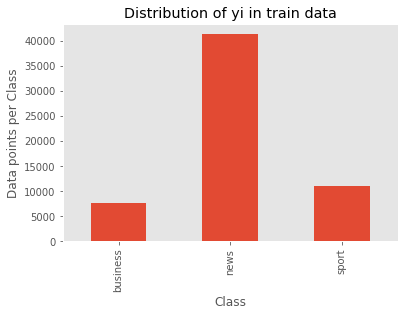

In [380]:
class_distribution = final_data['headline_category'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

In [20]:
final_data['headline_category'].value_counts()

news        41355
sport       11064
business     7581
Name: headline_category, dtype: int64

### converting categorical target variables into numeric values:

In [21]:
y=final_data['headline_category']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_true=le.fit_transform(y)
le.classes_

array(['business', 'news', 'sport'], dtype=object)

In [22]:
y_true

array([2, 1, 1, ..., 1, 2, 2])

In [23]:
final_data.head(3)

,publish_date,headline_category,headline_text
0,19960625,sport,O'Keeffe's approach suits Clare footballers
1,20110716,news,Developer who had rifle outside court escapes ...
2,20060922,news,Oil edges higher near $62 after 6-week slide


# Text Preprocessing :

In [24]:
import tqdm
import re
import nltk
import string
preprocessed_text=[]
for sentence in final_data['headline_text'].values:
    #removing white spaces 
    sentence = sentence.strip()
    #removing digits
    sentence =re.sub("\d+", "", sentence)
    #removing puntuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    #sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    preprocessed_text.append(' '.join(token.lower() for token in nltk.word_tokenize(sentence) if token.lower() not in stopwords.words('english')))

In [25]:
final_data['headline_text'] = pd.Series(preprocessed_text)

In [26]:
final_data.head(3)

,publish_date,headline_category,headline_text
0,19960625,sport,okeeffes approach suits clare footballers
1,20110716,news,developer rifle outside court escapes jail
2,20060922,news,oil edges higher near week slide


In [27]:
final_data=final_data.drop(columns= ['headline_category','publish_date'])

### spliting the data into train , cross validation and test sets :

In [60]:
X_train, x_test, y_train, y_test = train_test_split(final_data, y_true, stratify=y_true, test_size=0.2)
x_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

## Defining a function to print confusion, precision and recall matrices :

In [78]:
def calculate_confusion_precision_recall_matrices(y_true,y_predicted):
    C = confusion_matrix(y_true,y_predicted)
    P =C/(C.sum(axis=0))
    R =(C.T/C.sum(axis=1)).T
    print_confusion_precision_recall_matrices(C,"confusion_matrix")  
    print_confusion_precision_recall_matrices(P,"precision_matrix")  
    print_confusion_precision_recall_matrices(R,"Recall_matrix")  
def print_confusion_precision_recall_matrices(matrix,text):
    print(text)
    labels = ['business','news','sports']
    plt.figure(figsize=(10,5))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## <font color='blue'> Bag of words representation:</font>  

In [49]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
bow=vectorizer.fit(x_train['headline_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_one_hot = vectorizer.transform(x_train['headline_text'].values)
x_cv_one_hot = vectorizer.transform(x_cv['headline_text'].values)
x_test_one_hot = vectorizer.transform(x_test['headline_text'].values)

print("After vectorizations")
print(x_train_one_hot.shape, y_train.shape)
print(x_cv_one_hot.shape, y_cv.shape)
print(x_test_one_hot.shape, y_test.shape)


After vectorizations
(38400, 3886) (38400,)
(9600, 3886) (9600,)
(12000, 3886) (12000,)


## <font color='blue'>  TFidf Vectorizer:</font>  

In [70]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
tfidf_title=vectorizer.fit(x_train['headline_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_train_tfidf = vectorizer.transform(x_train['headline_text'].values)
x_cv_tfidf = vectorizer.transform(x_cv['headline_text'].values)
x_test_tfidf = vectorizer.transform(x_test['headline_text'].values)

print("After vectorizations")
print(x_train_tfidf.shape, y_train.shape)
print(x_cv_tfidf.shape, y_cv.shape)
print(x_test_tfidf.shape, y_test.shape)


After vectorizations
(38400, 3893) (38400,)
(9600, 3893) (9600,)
(12000, 3893) (12000,)


## <font color='blue'>  Avg W2V using glove vectors :</font>  

In [406]:
#credit: https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python

import numpy as np
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [407]:
model=loadGloveModel("glove.6B.50d.txt")
w2v_words=model.keys()

Loading Glove Model
Done. 400000  words loaded!


### vectorizing train text :

In [408]:
text_data_train=[]
for sentence in x_train['headline_text'].values:
    text_data_train.append(sentence.split())

In [409]:
import tqdm
w2v_train = []; 
for sent in tqdm.tqdm(text_data_train): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    w2v_train.append(sent_vec)
w2v_train = np.array(w2v_train)
print(w2v_train.shape)


100%|██████████| 38400/38400 [00:00<00:00, 68656.64it/s]

(38400, 50)


### Vectorizing cv text :

In [410]:
text_data_cv=[]
for text in  x_cv['headline_text'].values:
    text_data_cv.append(text.split())

In [411]:
w2v_cv= []; 
for sent in tqdm.tqdm(text_data_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    w2v_cv.append(sent_vec)
w2v_cv = np.array(w2v_cv)
print(w2v_cv.shape)

100%|██████████| 9600/9600 [00:00<00:00, 56873.85it/s]

(9600, 50)


### vectorizing test text :

In [412]:
text_data_test=[]
for text in  x_test['headline_text'].values:
    text_data_test.append(text.split())

In [413]:
w2v_test= []; 
for sent in tqdm.tqdm(text_data_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    w2v_test.append(sent_vec)
w2v_test = np.array(w2v_test)
print(w2v_test.shape)

100%|██████████| 12000/12000 [00:00<00:00, 61252.47it/s]

(12000, 50)


# <font color='blue'> Model 1: Logistic Regression + BOW :</font>  

### Finding the best hyperparamter for Logistic Regression Model :

In [392]:
import plotly.express as px

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_one_hot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_one_hot,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv_one_hot)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("for alpha = {} Log Loss is {} ".format(i,log_loss(y_cv, sig_clf_probs)))




df = pd.DataFrame({'alpha': alpha, 'error_cv': cv_log_error_array })
fig = px.line(df, x="alpha", y="error_cv",width=500,height=500,title="Cross Validation Error For Each alpha",log_x=True)
fig.show()



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_one_hot, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_one_hot, y_train)

predict_y = sig_clf.predict_proba(x_train_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06 Log Loss is 0.5372418321361376 
for alpha = 1e-05 Log Loss is 0.5184390780792215 
for alpha = 0.0001 Log Loss is 0.5139354221390859 
for alpha = 0.001 Log Loss is 0.5539227638332066 
for alpha = 0.01 Log Loss is 0.6075018026683777 
for alpha = 0.1 Log Loss is 0.6530562476780866 
for alpha = 1 Log Loss is 0.6766583586724095 
for alpha = 10 Log Loss is 0.6797165402237537 
for alpha = 100 Log Loss is 0.6801440142700951 


For values of best alpha =  0.0001 The train log loss is: 0.4412379692005343
For values of best alpha =  0.0001 The cross validation log loss is: 0.5139354221390859
For values of best alpha =  0.0001 The test log loss is: 0.5188519518317951


### Plotting confusion, recall and precision matrix :

confusion_matrix


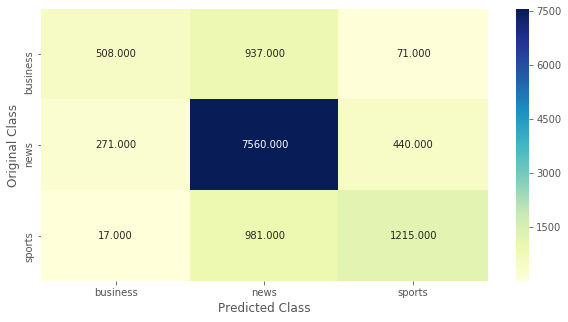

precision_matrix


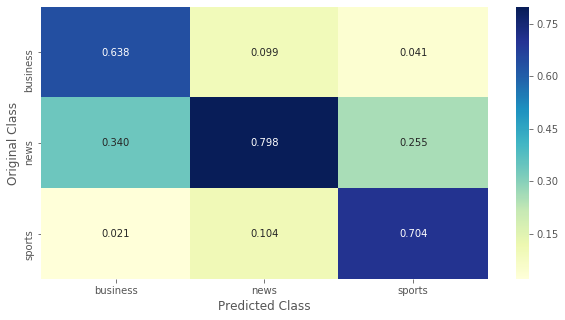

Recall_matrix


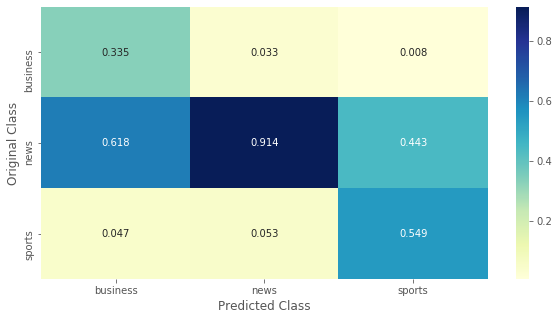

In [393]:
 calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(x_test_one_hot))

### Most important words for predicting the "news" class correctly:

### Plotting word cloud :

In [403]:
y_test=list(y_test)
X_test=x_test.reset_index(drop=True)
y_pred=sig_clf.predict(x_test_one_hot)

index_news_pred=[]
for index,element in enumerate(y_test):
    if element == 1:
        index_news_pred.append(index)
        
indices=[]
for i in index_news_pred:
    if y_test[i] == 1 :
        indices.append(i)
        
x_test_correctly_classified=X_test[X_test.index.isin(indices)]       


 The most frequent words : 
 
 


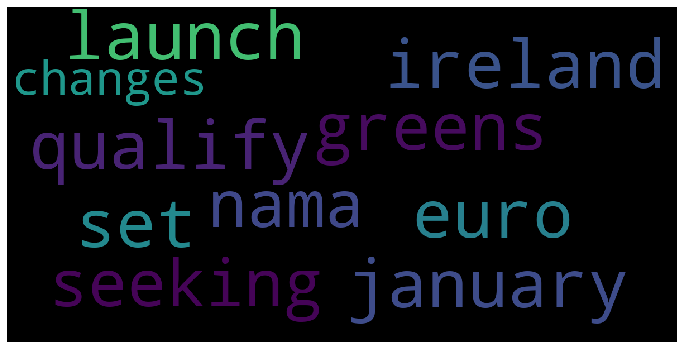

In [404]:

from wordcloud import WordCloud
from nltk.corpus import stopwords
Stopwords=stopwords.words('english')
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=Stopwords,
        max_words=10,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

print("\n The most frequent words : \n \n ")
show_wordcloud(x_test_correctly_classified['headline_text'])


# <font color='blue'> model-2 : Logistic Regression + TFidf Vectorizer :</font>  

### Applying Logistic Regression and hyperparameter tuning (alpha) :

In [79]:
import plotly.express as px

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_tfidf,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv_tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 



df = pd.DataFrame({'alpha': alpha, 'error_cv': cv_log_error_array })
fig = px.line(df, x="alpha", y="error_cv",width=500,height=500,title="Cross Validation Error For Each alpha",log_x=True)
fig.show()



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(x_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 0.5220254509229006
for alpha = 1e-05
Log Loss : 0.5083979888356063
for alpha = 0.0001
Log Loss : 0.5193713167080591
for alpha = 0.001
Log Loss : 0.5601152334050137
for alpha = 0.01
Log Loss : 0.5740507132449377
for alpha = 0.1
Log Loss : 0.5897612834346851
for alpha = 1
Log Loss : 0.6060260007834704
for alpha = 10
Log Loss : 0.6082727854187606
for alpha = 100
Log Loss : 0.6085748422917561


For values of best alpha =  1e-05 The train log loss is: 0.4229451830817061
For values of best alpha =  1e-05 The cross validation log loss is: 0.5083979888356063
For values of best alpha =  1e-05 The test log loss is: 0.511856238054213


## Plotting confusion, recall and precision matrix :

confusion_matrix


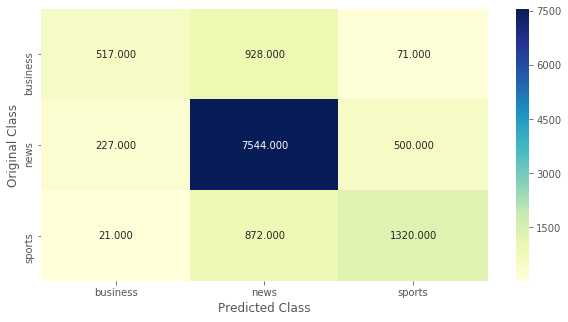

precision_matrix


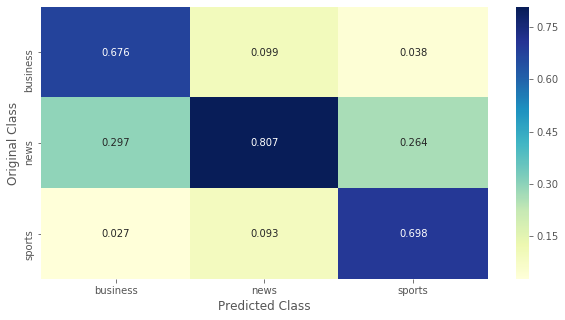

Recall_matrix


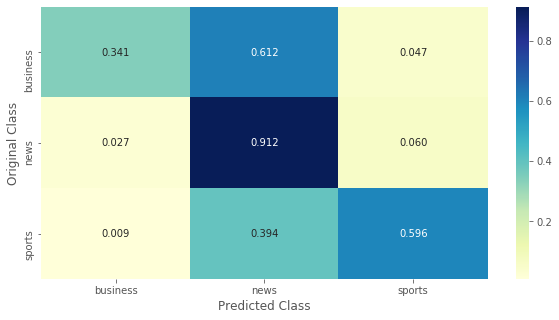

In [80]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(x_test_tfidf))

### Most important words for predicting the "news" class correctly:

In [34]:
y_test=list(y_test)
X_test=x_test.reset_index(drop=True)
y_pred=sig_clf.predict(x_test_tfidf)

index_news_pred=[]
for index,element in enumerate(y_test):
    if element == 1:
        index_news_pred.append(index)
        
indices=[]
for i in index_news_pred:
    if y_test[i] == 1 :
        indices.append(i)
        
x_test_correctly_classified=X_test[X_test.index.isin(indices)]       


 The most frequent words : 
 
 


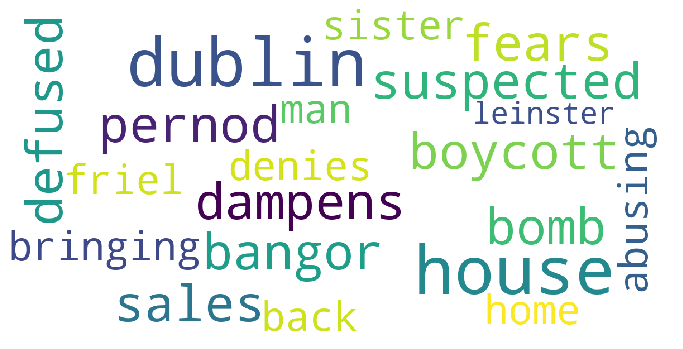

In [36]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
Stopwords=stopwords.words('english')
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=Stopwords,
        max_words=20,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

print("\n The most frequent words : \n \n ")
show_wordcloud(x_test_correctly_classified['headline_text'])


# <font color='blue'> model 3 : Logistic Regression + Avg W2V using glove vectors :</font>  

### Applying Logistic Regression and hyperparameter tuning (alpha) :

In [253]:
import plotly.express as px

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(w2v_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(w2v_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(w2v_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("for alpha = {} Log Loss is {} ".format(i,log_loss(y_cv, sig_clf_probs)))



df = pd.DataFrame({'alpha': alpha, 'error_cv': cv_log_error_array })
fig = px.line(df, x="alpha", y="error_cv",width=500,height=500,title="Cross Validation Error For Each alpha",log_x=True)
fig.show()



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(w2v_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(w2v_train, y_train)

predict_y = sig_clf.predict_proba(w2v_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(w2v_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(w2v_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06 Log Loss is 0.5371261331053406 
for alpha = 1e-05 Log Loss is 0.525488614337607 
for alpha = 0.0001 Log Loss is 0.5209670386240256 
for alpha = 0.001 Log Loss is 0.5212360814626111 
for alpha = 0.01 Log Loss is 0.5247115896760562 
for alpha = 0.1 Log Loss is 0.5410359730900357 
for alpha = 1 Log Loss is 0.5624333427146595 
for alpha = 10 Log Loss is 0.6565953236633602 
for alpha = 100 Log Loss is 0.7036412946971093 


For values of best alpha =  0.0001 The train log loss is: 0.5261676189613566
For values of best alpha =  0.0001 The cross validation log loss is: 0.5209670386240256
For values of best alpha =  0.0001 The test log loss is: 0.5415810485206101


confusion_matrix


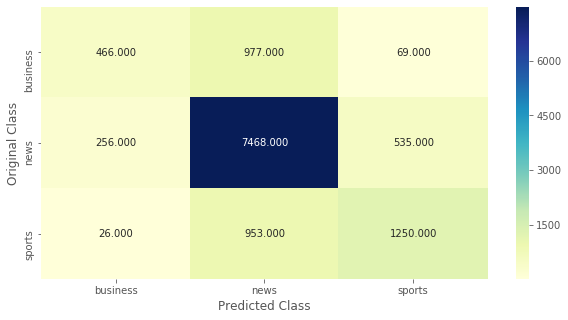

precision_matrix


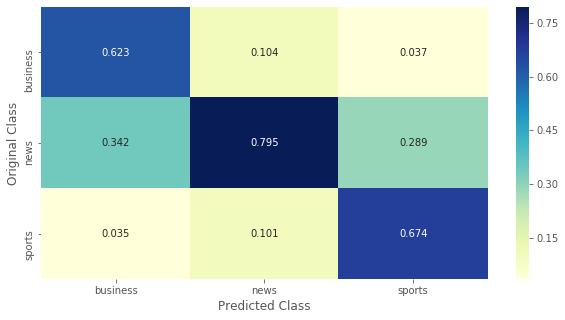

Recall_matrix


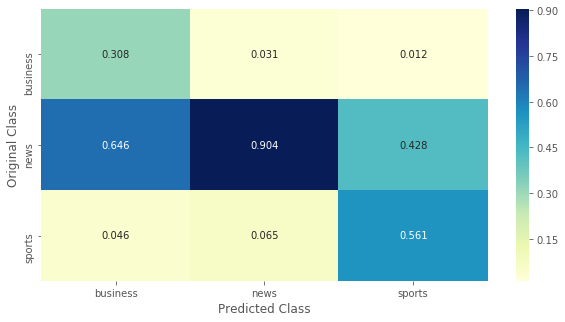

In [254]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(w2v_test))

### Most important words for predicting the "news" class correctly:

In [ ]:
y_test=list(y_test)
X_test=x_test.reset_index(drop=True)
y_pred=sig_clf.predict(w2v_test)

index_news_pred=[]
for index,element in enumerate(y_test):
    if element == 1:
        index_news_pred.append(index)
        
indices=[]
for i in index_news_pred:
    if y_test[i] == 1 :
        indices.append(i)
        
x_test_correctly_classified=X_test[X_test.index.isin(indices)]       

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
Stopwords=stopwords.words('english')
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=Stopwords,
        max_words=10,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

print("\n The most frequent words : \n \n ")
show_wordcloud(x_test_correctly_classified['headline_text'])


# <font color='blue'> model-4 : Suppport Vector Machines + BOW :</font>  

In [258]:
import plotly.express as px

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(x_train_one_hot, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_one_hot,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv_one_hot)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("for alpha = {} Log Loss is {} ".format(i,log_loss(y_cv, sig_clf_probs)))




df = pd.DataFrame({'alpha': alpha, 'error_cv': cv_log_error_array })
fig = px.line(df, x="alpha", y="error_cv",width=500,height=500,title="Cross Validation Error For Each alpha",log_x=True)
fig.show()



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(x_train_one_hot, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_one_hot, y_train)

predict_y = sig_clf.predict_proba(x_train_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_one_hot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06 Log Loss is 0.5371825519947092 
for alpha = 1e-05 Log Loss is 0.523581908599944 
for alpha = 0.0001 Log Loss is 0.5127169946052417 
for alpha = 0.001 Log Loss is 0.5449778181479639 
for alpha = 0.01 Log Loss is 0.5938864595699902 
for alpha = 0.1 Log Loss is 0.6641313597552663 
for alpha = 1 Log Loss is 0.6672795658726487 
for alpha = 10 Log Loss is 0.6672795658642032 
for alpha = 100 Log Loss is 0.6672795656138653 


For values of best alpha =  0.0001 The train log loss is: 0.43952736889562166
For values of best alpha =  0.0001 The cross validation log loss is: 0.5127169946052417
For values of best alpha =  0.0001 The test log loss is: 0.5263171954284037


### Plotting confusion, recall and precision matrix :

confusion_matrix


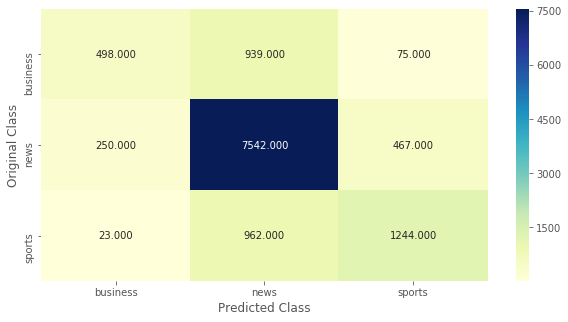

precision_matrix


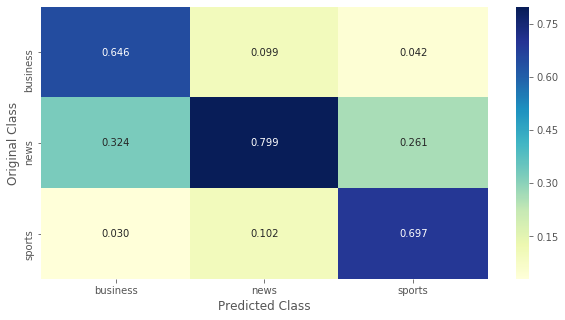

Recall_matrix


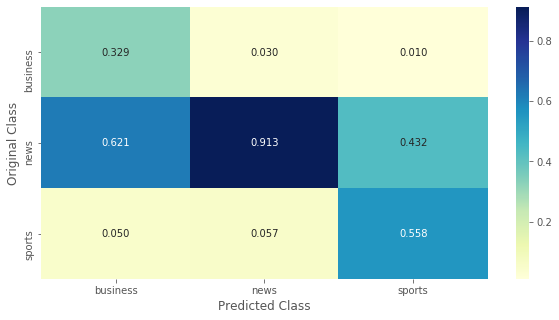

In [259]:
 calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(x_test_one_hot))

# <font color='blue'> model-5 : Suppport Vector Machines + Tfidf :</font>  

In [265]:
import plotly.express as px

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(x_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_tfidf,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv_tfidf)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("for alpha = {} Log Loss is {} ".format(i,log_loss(y_cv, sig_clf_probs)))



df = pd.DataFrame({'alpha': alpha, 'error_cv': cv_log_error_array })
fig = px.line(df, x="alpha", y="error_cv",width=500,height=500,title="Cross Validation Error For Each alpha",log_x=True)
fig.show()



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(x_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06 Log Loss is 0.5333662355135974 
for alpha = 1e-05 Log Loss is 0.5192506821153298 
for alpha = 0.0001 Log Loss is 0.5189883031160081 
for alpha = 0.001 Log Loss is 0.5720495964895121 
for alpha = 0.01 Log Loss is 0.5740185855343931 
for alpha = 0.1 Log Loss is 0.6086855015071626 
for alpha = 1 Log Loss is 0.6086855014956097 
for alpha = 10 Log Loss is 0.6086855016120526 
for alpha = 100 Log Loss is 0.6086855017308452 


For values of best alpha =  0.0001 The train log loss is: 0.4661861643296565
For values of best alpha =  0.0001 The cross validation log loss is: 0.5196442702821394
For values of best alpha =  0.0001 The test log loss is: 0.6075054400248009


### Plotting confusion, recall and precision matrix :

confusion_matrix


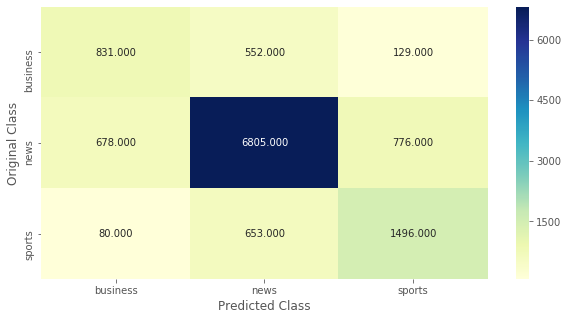

precision_matrix


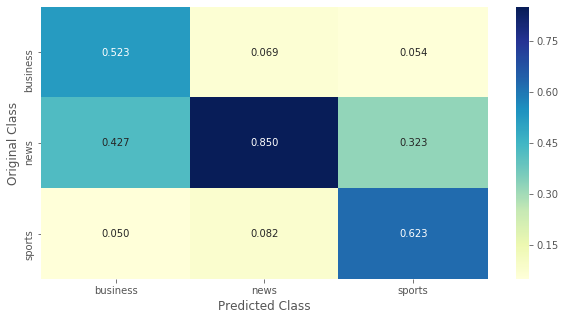

Recall_matrix


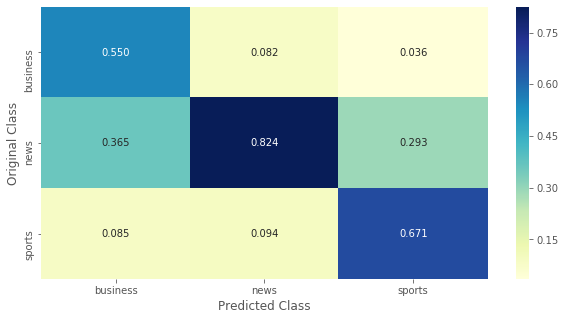

In [266]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(x_test_tfidf))

# <font color='blue'> model 6 : Support Vector Machines + word2vec :</font>  

In [269]:
import plotly.express as px

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(w2v_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(w2v_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(w2v_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("for alpha = {} Log Loss is {} ".format(i,log_loss(y_cv, sig_clf_probs)))



df = pd.DataFrame({'alpha': alpha, 'error_cv': cv_log_error_array })
fig = px.line(df, x="alpha", y="error_cv",width=500,height=500,title="Cross Validation Error For Each alpha",log_x=True)
fig.show()



best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(w2v_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(w2v_train, y_train)

predict_y = sig_clf.predict_proba(w2v_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(w2v_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(w2v_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06 Log Loss is 0.5478559334427483 
for alpha = 1e-05 Log Loss is 0.5320243958004786 
for alpha = 0.0001 Log Loss is 0.5223252552900376 
for alpha = 0.001 Log Loss is 0.522979784452501 
for alpha = 0.01 Log Loss is 0.5240588008427954 
for alpha = 0.1 Log Loss is 0.5346427340192981 
for alpha = 1 Log Loss is 0.5469930303993571 
for alpha = 10 Log Loss is 0.6828242265989094 
for alpha = 100 Log Loss is 0.7308484303639415 


For values of best alpha =  0.0001 The train log loss is: 0.5261676189613566
For values of best alpha =  0.0001 The cross validation log loss is: 0.5209670386240256
For values of best alpha =  0.0001 The test log loss is: 0.5415810485206101


### Plotting confusion, recall and precision matrix :

confusion_matrix


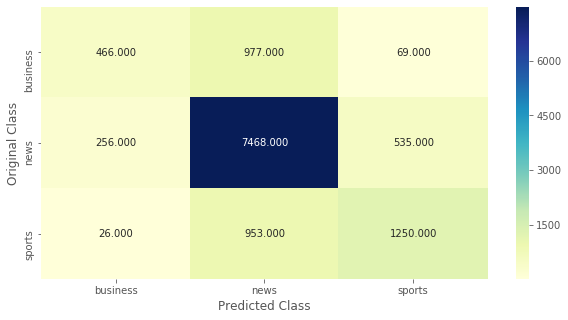

precision_matrix


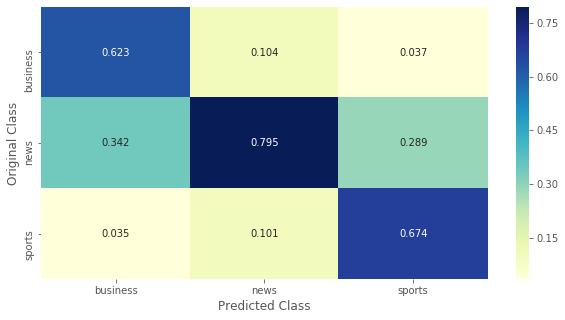

Recall_matrix


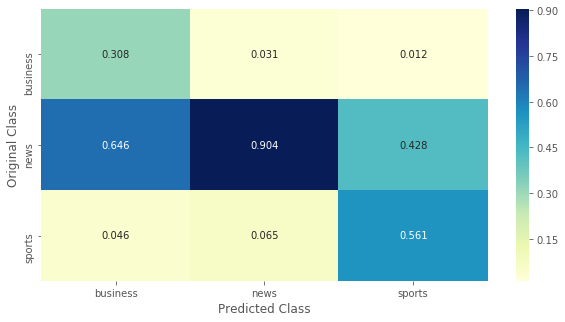

In [270]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(w2v_test))

# <font color='blue'> Model 10 : Random Forest + BOW :</font>  

In [54]:
import plotly.express as px

n_estimator = [100,200,500,1000,2000]
max_depth = [3,5,10,15,20]
cv_log_error_array = []
x_max_depth=[]
y_n_estimator=[]
for i in max_depth:
    for j in n_estimator:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(x_train_one_hot, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train_one_hot,y_train)
        sig_clf_probs = sig_clf.predict_proba(x_cv_one_hot)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("for no of estimator = {} and max depth = {}  Log Loss is {} ".format(i,j,log_loss(y_cv, sig_clf_probs)))
        x_max_depth.append(i)
        y_n_estimator.append(j)

df = pd.DataFrame({'n_estimator': y_n_estimator, "max_depth":x_max_depth,'error_cv': cv_log_error_array })
fig = px.line_3d(df, x="n_estimator", y="max_depth",z='error_cv',title="Cross Validation Error For Each alpha")
fig.show()

best_index = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=y_n_estimator[best_index], criterion='gini', max_depth=x_max_depth[best_index], random_state=42, n_jobs=-1)
clf.fit(x_train_one_hot, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_one_hot, y_train)
predict_y = sig_clf.predict_proba(x_train_one_hot)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_one_hot)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index] ,"The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_one_hot)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for no of estimator = 3 and max depth = 100  Log Loss is 0.7092486922645926 
for no of estimator = 3 and max depth = 200  Log Loss is 0.6869213603324861 
for no of estimator = 3 and max depth = 500  Log Loss is 0.6690250014745235 
for no of estimator = 3 and max depth = 1000  Log Loss is 0.665283101794827 
for no of estimator = 3 and max depth = 2000  Log Loss is 0.6637797906321414 
for no of estimator = 5 and max depth = 100  Log Loss is 0.6948189689917492 
for no of estimator = 5 and max depth = 200  Log Loss is 0.6729291086936283 
for no of estimator = 5 and max depth = 500  Log Loss is 0.651922267509491 
for no of estimator = 5 and max depth = 1000  Log Loss is 0.6488609338063382 
for no of estimator = 5 and max depth = 2000  Log Loss is 0.6468675838235284 
for no of estimator = 10 and max depth = 100  Log Loss is 0.6800186881647022 
for no of estimator = 10 and max depth = 200  Log Loss is 0.661782168627606 
for no of estimator = 10 and max depth = 500  Log Loss is 0.6398212460550

For values of best n_estimator=  2000 For values of best max_depth=  20 The train log loss is: 0.6446286815123873
For values of best n_estimator=  2000 For values of best max_depth=  20 The cross validation log loss is: 0.6888027637704057
For values of best n_estimator=  2000 For values of best max_depth=  20 The test log loss is: 0.6897123845860514


### Plotting confusion, recall and precision matrix :

confusion_matrix


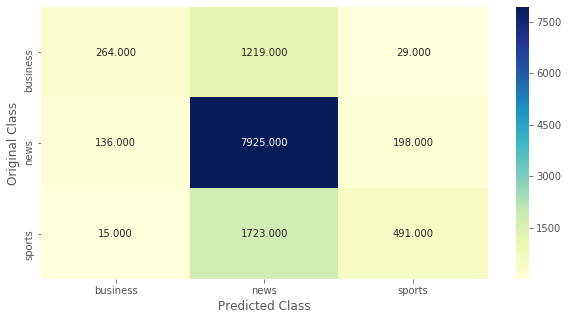

precision_matrix


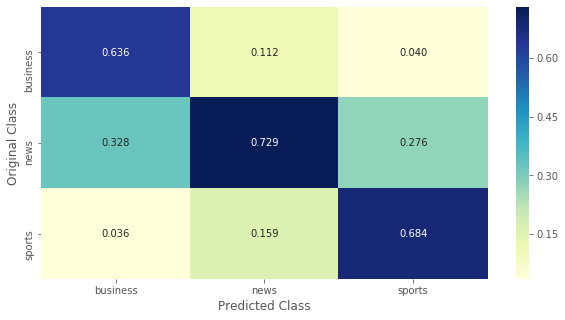

Recall_matrix


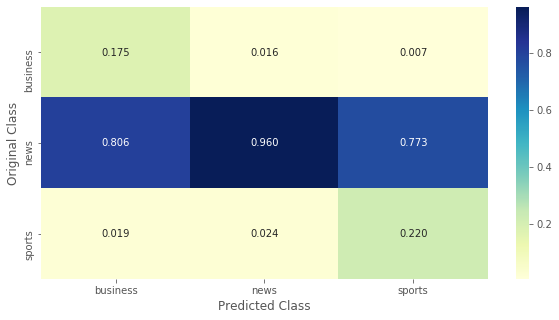

In [300]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(x_test_one_hot))

 # <font color='blue'> Model 11 : Random Forest + Tfidf :</font>  

In [39]:
import plotly.express as px

n_estimator = [100,200,500,1000,2000]
max_depth = [3,5,10,15,20]
cv_log_error_array = []
x_max_depth=[]
y_n_estimator=[]
for i in max_depth:
    for j in n_estimator:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(x_train_tfidf, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train_tfidf,y_train)
        sig_clf_probs = sig_clf.predict_proba(x_cv_tfidf)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("for no of estimator = {} and max depth = {}  Log Loss is {} ".format(i,j,log_loss(y_cv, sig_clf_probs)))
        x_max_depth.append(i)
        y_n_estimator.append(j)

df = pd.DataFrame({'n_estimator': y_n_estimator, "max_depth":x_max_depth,'error_cv': cv_log_error_array })
fig = px.line_3d(df, x="n_estimator", y="max_depth",z='error_cv',title="Cross Validation Error For Each alpha")
fig.show()

best_index = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
clf.fit(x_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_tfidf,y_train)
predict_y = sig_clf.predict_proba(x_train_tfidf)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_tfidf)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index] ,"The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_tfidf)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for no of estimator = 3 and max depth = 100  Log Loss is 0.7096103282143242 
for no of estimator = 3 and max depth = 200  Log Loss is 0.6809655360296978 
for no of estimator = 3 and max depth = 500  Log Loss is 0.6547736623074294 
for no of estimator = 3 and max depth = 1000  Log Loss is 0.6388716164389056 
for no of estimator = 3 and max depth = 2000  Log Loss is 0.6324278076409902 
for no of estimator = 5 and max depth = 100  Log Loss is 0.6914463394926226 
for no of estimator = 5 and max depth = 200  Log Loss is 0.667008398612354 
for no of estimator = 5 and max depth = 500  Log Loss is 0.6361635504834047 
for no of estimator = 5 and max depth = 1000  Log Loss is 0.6218591270538292 
for no of estimator = 5 and max depth = 2000  Log Loss is 0.614223242913092 
for no of estimator = 10 and max depth = 100  Log Loss is 0.6762632016899841 
for no of estimator = 10 and max depth = 200  Log Loss is 0.6513366211787086 
for no of estimator = 10 and max depth = 500  Log Loss is 0.621944060055

For values of best n_estimator=  2000 For values of best max_depth=  20 The train log loss is: 0.3139497214834398
For values of best n_estimator=  2000 For values of best max_depth=  20 The cross validation log loss is: 0.5896684651026186
For values of best n_estimator=  2000 For values of best max_depth=  20 The test log loss is: 0.5886674757305246


### Ploting confusion matrix :

confusion_matrix


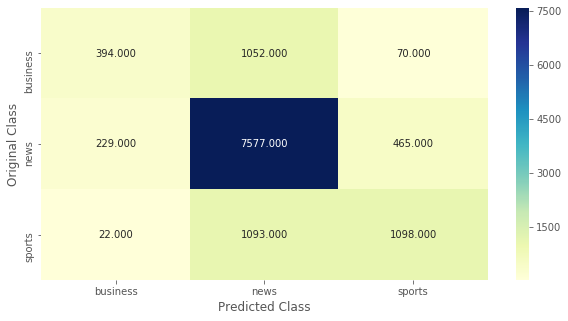

precision_matrix


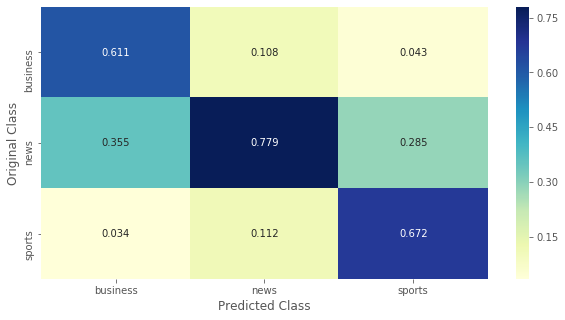

Recall_matrix


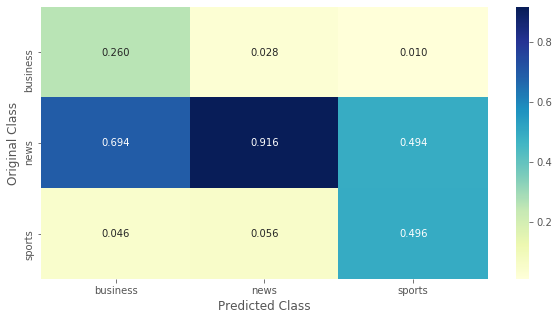

In [40]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(x_test_tfidf))

# <font color='blue'> Model 12 :  Random Forest + Avg w2v (using glove vectors) :</font> 

In [305]:
import plotly.express as px

n_estimator = [100,200,500,1000,2000]
max_depth = [3,5,10,15,20]
cv_log_error_array = []
x_max_depth=[]
y_n_estimator=[]
for i in max_depth:
    for j in n_estimator:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(w2v_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(w2v_train,y_train)
        sig_clf_probs = sig_clf.predict_proba(w2v_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_,eps=1e-15))
        print("for no of estimator = {} and max depth = {}  Log Loss is {} ".format(i,j,log_loss(y_cv, sig_clf_probs)))
        x_max_depth.append(i)
        y_n_estimator.append(j)

df = pd.DataFrame({'n_estimator': y_n_estimator, "max_depth":x_max_depth,'error_cv': cv_log_error_array })
fig = px.line_3d(df, x="n_estimator", y="max_depth",z='error_cv',title="Cross Validation Error For n_estimator and max_depth")
fig.show()

best_index = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
clf.fit(w2v_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(w2v_train,y_train)
    
predict_y = sig_clf.predict_proba(w2v_train)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(w2v_cv)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index] ,"The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(w2v_test)
print('For values of best n_estimator= ', y_n_estimator[best_index],'For values of best max_depth= ', x_max_depth[best_index], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))





for no of estimator = 3 and max depth = 100  Log Loss is 0.6375190024411875 
for no of estimator = 3 and max depth = 200  Log Loss is 0.6375190024411875 
for no of estimator = 3 and max depth = 500  Log Loss is 0.6375190024411875 
for no of estimator = 3 and max depth = 1000  Log Loss is 0.6375190024411875 
for no of estimator = 3 and max depth = 2000  Log Loss is 0.6375190024411875 
for no of estimator = 5 and max depth = 100  Log Loss is 0.5999636280642028 
for no of estimator = 5 and max depth = 200  Log Loss is 0.5999636280642028 
for no of estimator = 5 and max depth = 500  Log Loss is 0.5999636280642028 
for no of estimator = 5 and max depth = 1000  Log Loss is 0.5999636280642028 
for no of estimator = 5 and max depth = 2000  Log Loss is 0.5999636280642028 
for no of estimator = 10 and max depth = 100  Log Loss is 0.5570931360015247 
for no of estimator = 10 and max depth = 200  Log Loss is 0.5570931360015247 
for no of estimator = 10 and max depth = 500  Log Loss is 0.5570931360

For values of best n_estimator=  100 For values of best max_depth=  20 The train log loss is: 0.22405676466566396
For values of best n_estimator=  100 For values of best max_depth=  20 The cross validation log loss is: 0.5340263687770365
For values of best n_estimator=  100 For values of best max_depth=  20 The test log loss is: 0.5523793394735291


### plot confusion matrix :

confusion_matrix


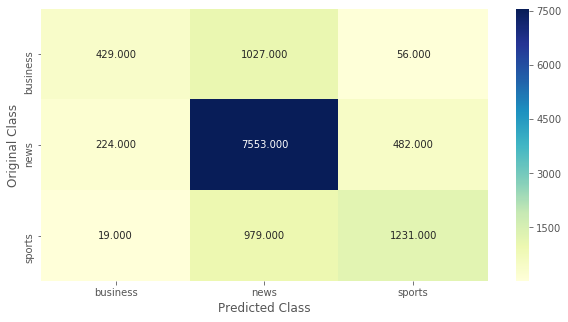

precision_matrix


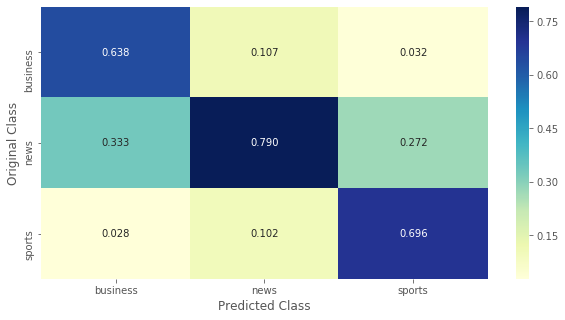

Recall_matrix


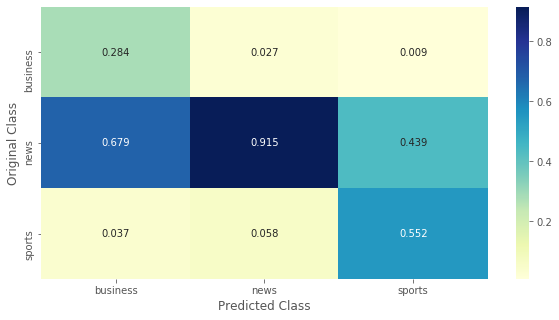

In [306]:
calculate_confusion_precision_recall_matrices(y_test,sig_clf.predict(w2v_test))

# conclusion :

In [46]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Sl NO","MODELS","HYPERPARAMETERS","TRAIN_ERROR","CV_ERROR","TEST_ERROR"]
table.add_row([1,'LR + BOW' ,'alpha=0.0001','0.441','0.513','0.518'])
table.add_row([2,'LR + TFIDF'  ,'alpha=0.00001','0.421','0.508','0.557'])
table.add_row([3,'LR + W2V'  ,'alpha=0.0001','0.526','0.520','0.541'])
table.add_row([4,'SVM + BOW'  ,'alpha=0.0001','0.439','0.512','0.526'])
table.add_row([5,'SVM + TFIDF'  ,'alpha=0.0001','0.466','0.519','0.607'])
table.add_row([6,'SVM + W2V'  ,'alpha=0.0001','0.526','0.520','0.541'])
table.add_row([7,'RF + BOW'  ,'n_estimator=2000,max_depth=20','0.648','0.688','0.7'])
table.add_row([8,'RF + TFIDF'  ,'n_estimator=2000,max_depth=20','0.316','0.590','0.588'])
table.add_row([9,'RF+ W2V'  ,'n_estimator=100,max_depth=20','0.224','0.534','0.552'])

print(table)

+-------+-------------+-------------------------------+-------------+----------+------------+
| Sl NO |    MODELS   |        HYPERPARAMETERS        | TRAIN_ERROR | CV_ERROR | TEST_ERROR |
+-------+-------------+-------------------------------+-------------+----------+------------+
|   1   |   LR + BOW  |          alpha=0.0001         |    0.441    |  0.513   |   0.518    |
|   2   |  LR + TFIDF |         alpha=0.00001         |    0.421    |  0.508   |   0.557    |
|   3   |   LR + W2V  |          alpha=0.0001         |    0.526    |  0.520   |   0.541    |
|   4   |  SVM + BOW  |          alpha=0.0001         |    0.439    |  0.512   |   0.526    |
|   5   | SVM + TFIDF |          alpha=0.0001         |    0.466    |  0.519   |   0.607    |
|   6   |  SVM + W2V  |          alpha=0.0001         |    0.526    |  0.520   |   0.541    |
|   7   |   RF + BOW  | n_estimator=2000,max_depth=20 |    0.648    |  0.688   |    0.7     |
|   8   |  RF + TFIDF | n_estimator=2000,max_depth=20 |    0

## CONCLUSION :

- LR+ W2V and SVM + W2V are performing better than other models . As the train error , cv error and test error are almost overlapping . Model does not overfit the training data.